# 8. 「1. E-Cell4を用いたシミュレーションの概要」についてより詳しく

一度[1. E-Cell4を用いたシミュレーションの概要](tutorial1-ja.ipynb)を読んだ後は、`World` と `Simulator` を使うのは難しくありません。
`volume` と {'C' : 60} は `World` に相当し、ソルバーは以下の `Simulator` に相当します。


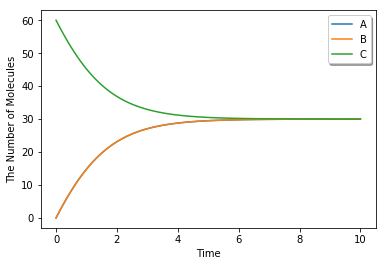

In [1]:
%matplotlib inline
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

run_simulation(10.0, {'C': 60}, volume=1.0)


ここでは `run_simulation` がその内部で行っていることを分解して示します。
`run_simulation` はデフォルトでODEシミュレータを使用するので、`ode.World` を段階的に作成してみましょう。


## 8.1. ode.World の作成

`World` はこのようにして作ることができます。


In [2]:
from ecell4_base.core import *
from ecell4_base import *

In [3]:
w = ode.World(Real3(1, 1, 1))

`Real3` は座標ベクトルです。

この例では、 `ode.World` コンストラクタの最初の引数は立方体を表しています。

`run_simulation` 引数のように、`ode.World` 引数には`volume`を使用できないことに注意してください。

今度はシミュレーション用の立方体の空間を作成した後、分子をその立方体中に投げ込みましょう。


In [4]:
w = ode.World(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)
print(w.t(), w.num_molecules(Species('C')))  # must return (0.0, 60)

0.0 60


分子を追加するには `add_molecules`、分子を削除するには` remove_molecules`、分子の数を知るには `num_molecules` を使います。

各メソッドの第一引数は、あなたが知りたい `Species` です。

`t` メソッドで現在時刻を取得できます。

しかし、ODEソルバーの分子数は実数であり、これらの `_molecules` 関数では整数に対してのみ動作します。

ODEで実数を扱うときは、 `set_value` と `get_value` を使います。


## 8.2. Real3 の使い方

`Simulator` の詳細の前に、`Real3` について詳しく説明します。


In [5]:
pos = Real3(1, 2, 3)
print(pos)  # must print like <ecell4.core.Real3 object at 0x7f44e118b9c0>
print(tuple(pos))  # must print (1.0, 2.0, 3.0)

(1.0, 2.0, 3.0)


`Real3` オブジェクトの内容を直接`print`することはできません。

`Real3` をPythonタプルまたはリストに一度変換する必要があります。


In [6]:
pos1 = Real3(1, 1, 1)
x, y, z = pos[0], pos[1], pos[2]
pos2 = pos1 + pos1
pos3 = pos1 * 3
pos4 = pos1 / 5
print(length(pos1))  # must print 1.73205080757
print(dot_product(pos1, pos3))  # must print 9.0

1.7320508075688772
9.0


`dot_product` のような基本的な関数も使えます。

もちろん、`Real3` をnumpyの配列に変換することもできます。


In [7]:
import numpy
a = numpy.asarray(tuple(Real3(1, 2, 3)))
print(a)  # must print [ 1.  2.  3.]

[1. 2. 3.]


`Integer3` は整数のトリプレットになります。


In [8]:
g = Integer3(1, 2, 3)
print(tuple(g))

(1, 2, 3)


もちろん、単純な算術演算を `Integer3` に適用することもできます。


In [9]:
print(tuple(Integer3(1, 2, 3) + Integer3(4, 5, 6)))  # => (5, 7, 9)
print(tuple(Integer3(4, 5, 6) - Integer3(1, 2, 3)))  # => (3, 3, 3)
print(tuple(Integer3(1, 2, 3) * 2))  # => (2, 4, 6)
print(dot_product(Integer3(1, 2, 3), Integer3(4, 5, 6)))  # => 32
print(length(Integer3(1, 2, 3)))  # => 3.74165738677

(5, 7, 9)
(3, 3, 3)
(2, 4, 6)
32
3.7416573867739413


## 8.3. ODESimulator の作成と実行

下記のように `Model` と `World` を使って `Simulator`を作成することができます。


In [10]:
with reaction_rules():
    A + B > C | 0.01  # equivalent to create_binding_reaction_rule
    C > A + B | 0.3   # equivalent to create_unbinding_reaction_rule

m = get_model()

sim = ode.Simulator(w, m)
sim.run(10.0)

`run` メソッドを呼び出すと、シミュレーションが実行されます。

この例では、シミュレーションは10秒間実行されます。

また `World` の状態は下記のようにしてチェックできます。


In [11]:
print(w.t(), w.num_molecules(Species('C')))  # must return (10.0, 30)

10.0 30


`Species` `C` の数が60から30に減少していることがわかります。

`World` はある時点での状態を表しているため、`World` でシミュレーションの遷移を見ることはできません。

時系列の結果を得るには、 `Observer` を使います。


In [12]:
w = ode.World(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)
sim = ode.Simulator(w, m)

obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10.0, obs)
print(obs.data())  # must return [[0.0, 0.0, 60.0], ..., [10.0, 29.994446899691276, 30.005553100308752]]

[[0.0, 0.0, 60.0], [0.1, 1.7722206143224584, 58.22777938567754], [0.2, 3.4860124975248006, 56.51398750247521], [0.30000000000000004, 5.137633294323578, 54.862366705676436], [0.4, 6.7240908315276045, 53.27590916847241], [0.5, 8.2431297778128, 51.75687022218721], [0.6000000000000001, 9.693203786964157, 50.30679621303585], [0.7000000000000001, 11.073435610343822, 48.926564389656185], [0.8, 12.383567710238625, 47.61643228976138], [0.9, 13.623905934263576, 46.37609406573643], [1.0, 14.795258697983998, 45.204741302016004], [1.1, 15.898873915953542, 44.101126084046456], [1.2000000000000002, 16.936375649258018, 43.06362435074198], [1.3, 17.909702127696086, 42.090297872303914], [1.4000000000000001, 18.821046480898254, 41.17895351910174], [1.5, 19.672801194656238, 40.32719880534375], [1.6, 20.467507011344757, 39.532492988655235], [1.7000000000000002, 21.207806726765288, 38.7921932732347], [1.8, 21.896404106006866, 38.10359589399312], [1.9000000000000001, 22.53602795042438, 37.4639720495756], [2.

E-Cell4にはいくつかのタイプの `Observer` があります。

`FixedIntervalNumberObserver` は、時系列の結果を得るための最もシンプルな `Observer` です。

その名前が示唆するように、この `Observer` は各時間ステップの分子の数を記録します。

第1引数は時間ステップ、第2引数は分子種です。

その結果は `data` メソッドで確認できますが、これにはショートカットがあります。


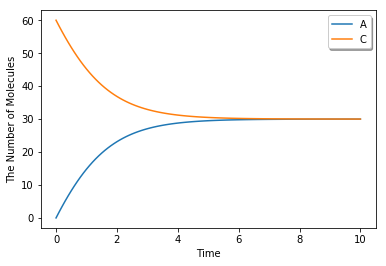

In [13]:
show(obs)

上記は時系列の結果を簡単にプロットします。

ここでは `run_simulation` 関数の内部について説明しました。

`Simulator ` を作成した後に ` World` を変更した場合は `Simulator` にそれを示す必要があります。

またそのあとで `sim.initialize()` を呼び出すことを忘れないでください。


## 8.4. ソルバーの差し替えについて

`run_simulation` の内部を上記で示したので、ソルバーを確率論的手法に替えることは難しくないでしょう。


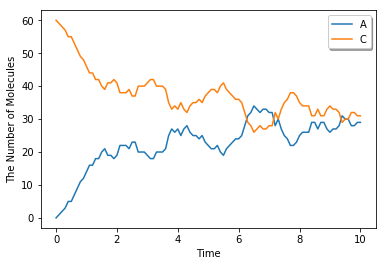

In [14]:
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

# ode.World -> gillespie.World
w = gillespie.GillespieWorld(Real3(1, 1, 1))
w.add_molecules(Species('C'), 60)

# ode.Simulator -> gillespie.Simulator
sim = gillespie.GillespieSimulator(w, m)
obs = FixedIntervalNumberObserver(0.1, ('A', 'C'))
sim.run(10.0, obs)

viz.plot_number_observer(obs)

`World` と `Simulator` は `Model` 自体を決して変更しないので、一つの `Model` に対して 複数の `Simulator` を差し替えることができます。
